<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# **Procesamiento de Lenguaje Natural**
# **Desafío 3: Modelo de lenguaje con tokenización por caracteres**

> **Carrera de Especialización en Inteligencia Artificial, Facultad de Ingeniería**
>
> **Universidad de Buenos Aires, Junio de 2024**
>
> Edgar David Guarin Castro (davidg@marketpsychdata.com)

En el presente trabajo se usa el dataset de [notícias financieras de Reuters](https://github.com/duynht/financial-news-dataset) con el fin de:
- realizar un pre-procesamiento para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determinístico y estocástico. En este último caso se busca observar el efecto de la temperatura en la generación de secuencias.

## **0. Importando librerías**

In [1]:
import os

import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, TimeDistributed, CategoryEncoding, SimpleRNN
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

## **1. Cargando los datos**

El dataset de noticias financieras contiene 109,110 noticias de Reuters, recopiladas y utilizadas por primera vez en una investigación de [Ding et al. (2014)](https://emnlp2014.org/papers/pdf/EMNLP2014148.pdf). El dataset se ha utilizado en otros estudios de predicción de movimientos del precio de acciones basados en eventos estructurados.

Despues de clonar el repositório, una carpeta llamada *financial-news-dataset* con todos los artículos, es creada en el directorio local:

In [2]:
#-----------------
# Clonando el repositorio
#-----------------
!git clone https://github.com/duynht/financial-news-dataset.git

Cloning into 'financial-news-dataset'...
remote: Enumerating objects: 109112, done.
remote: Total 109112 (delta 0), reused 0 (delta 0), pack-reused 109112
Receiving objects: 100% (109112/109112), 162.92 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (1046/1046), done.
Updating files: 100% (106523/106523), done.


Los artículos del corpus son cargados a un dataframe. Se escogen los 100 primeros artículos para facilitar los cálculos:

In [2]:
#-----------------
# Función para leer todas las noticias
#-----------------
def read_news(directory):
    news = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='latin-1') as f:
                news.append(f.read())
    return news

#-----------------
# Leyendo las noticias del directorio ReutersNews106521
#-----------------
news = read_news('financial-news-dataset/ReutersNews106521')

#-----------------
# Creando un DataFrame con la mitad de las noticias
#-----------------
df = pd.DataFrame(news, columns=['article'])

df = df[:100]

df

,article
0,   Bud1                                  ...
1,"-- Hitachi, GE boost alliance in nuclear power..."
2,"-- Volvo to cut 1,000 staff at Virginia plant\..."
3,-- European banks hiding full pension obligati...
4,"-- Hitachi, GE to form joint nuclear power ven..."
...,...
95,-- Darden Restaurants sales mixed in March\n--...
96,-- Gap to offer limited-edition designer colle...
97,-- KKR confirms dropped out of Sainsbury biddi...
98,-- Wal-Mart expands personal well-being progra...


## **2. Creando el vocabulario**

Con los artículos seleccionados, se escoge el tamaño del contexto y se crea el vocabulario de caracteres seleccionando los caracteres únicos:

In [3]:
#-----------------
# Seleccionando el tamaño de contexto
#-----------------
max_context_size = 100

#-----------------
# Uniendo todos los artículos en un solo string
#-----------------
all_text = ' '.join(df['article'].tolist())

#-----------------
# Creando el conjunto de caracteres únicos
#-----------------
chars_vocab = sorted(set(all_text))

vocab_size = len(chars_vocab)

print(f"Tamaño del vocabulario: {vocab_size}")

Tamaño del vocabulario: 97


Usando el vocabulario, se construyen los dicionarios que asignan índices a caracteres y viceversa:

In [4]:
#-----------------
# El diccionario `char2idx` servirá como tokenizador
#-----------------
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

#-----------------
# tokenizando el texto completo
#-----------------
tokenized_text = [char2idx[ch] for ch in all_text]
print(f"Número de tokens: {len(tokenized_text)}")

Número de tokens: 281475


Se separa a continuación el dataset en un conjunto de entrenamiento y validación. La variable `p_val` guardará la proporción del corpus (10%) que se reservará para validación. La variable `num_val` guardará la cantidad de secuencias de tamaño `max_context_size` que se usará en la validación:

In [31]:
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

#-----------------
# Separando la porción de texto utilizada en entrenamiento de la de validación.
#-----------------
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

## **3. Definiendo el modelo**

Este modelo de lenguaje de caracteres está diseñado para predecir el siguiente carácter en una secuencia dada. La secuencia se codifica como one-hot y se procesa a través de una capa RNN, que captura dependencias temporales en los datos. Luego, una capa densa con activación softmax produce una distribución de probabilidad sobre el vocabulario para predecir el siguiente carácter en la secuencia.

Para llevar a cabo este proceso se hace lo siguiente:
- se inicializa el modelo con la función `Sequential` de Keras, que permite apilar capas de redes neuronales una sobre otra en orden secuencial.
- se adiciona una capa `TimeDistributed` que aplica una capa `CategoryEncoding` en cada paso de tiempo de una secuencia. Esto asegura que la codificación se aplique a cada carácter en la secuencia independientemente. `CategoryEncoding` por su parte realiza la codificación one-hot de cada carácter en la secuencia. Dado que vocab_size representa el número total de caracteres únicos en el vocabulario, esta capa convierte cada carácter en un vector de longitud vocab_size donde un único elemento es 1 (el que corresponde al índice del carácter) y los demás son 0. `input_shape=(None,1)` especifica que la entrada tendrá una longitud variable (por eso el None) y cada carácter se representa inicialmente como un entero (por eso el 1).
- se adiciona una capa recurrente simple (RNN), que procesa secuencia de caracteres. Esta capa tiene 200 unidades (o neuronas), lo que significa que la salida de esta capa será un vector de 200 dimensiones para cada carácter en la secuencia.
- se adiciona una capa `Dense` completamente conectada donde cada uno de los 200 valores que vienen de la RNN se conectará a cada uno de los nodos `vocab_size` en esta capa.
- se compila el modelo usando `loss='sparse_categorical_crossentropy'` para implementar la función de pérdida sparse_categorical_crossentropy, que es adecuada cuando las etiquetas de destino son enteros como los índices de los caracteres. Esta función mide la diferencia entre las distribuciones de probabilidad predicha y la real. La función `optimizer='rmsprop'` es un optimizador usado para tareas de procesamiento de secuencias. Ajusta los pesos del modelo para minimizar la función de pérdida, y es adecuado para problemas de series temporales y secuencias debido a su capacidad de manejar el decaimiento adaptativo del aprendizaje.
- Finalmente, se imprime un resumen del modelo que muestra la estructura de las capas, el número de parámetros (pesos) en cada capa, y la cantidad total de parámetros del modelo.


In [35]:
#-----------------
# Inicializando el modelo
#-----------------
model = Sequential()

#-----------------
# Adicionando las capas
#-----------------
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

#-----------------
# Imprimiendo la estructura del modelo
#-----------------
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 97)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        59,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 97)       │        19,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,097 (308.97 KB)

 Trainable params: 79,097 (308.97 KB)

 Non-trainable params: 0 (0.00 B)

Para calcular la perplejidad en el conjunto de datos de validación al final de cada época, se define la clase `PplCallback`. Esta clase también aplica early stopping si el rendimiento no mejora después de un número específico de épocas. Esto ayuda a asegurar que el modelo no se sobreajuste y que se mantenga la mejor versión del modelo entrenado:

In [37]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

## **4. Entrenamiento**

A continuación se entrena el modelo de lenguaje de caracteres y al mismo tiempo se monitorea la perplejidad en el conjunto de validación para evaluar el rendimiento del modelo. Después del entrenamiento, se grafica la evolución de la perplejidad a lo largo de las épocas para visualizar cómo ha mejorado (o no) el modelo. Esta gráfica es crucial para entender si el modelo se está ajustando bien a los datos o si se está produciendo sobreajuste o estancamiento.

Durante el ajuste, se agrega un `callback` para evaluar la perplejidad del modelo en el conjunto de validación al final de cada época. La perplejidad se guarda en la lista `history_ppl` y se implementa early stopping si la perplejidad no mejora después de un número definido de épocas (patience). El `batch_size` se puede seleccionar a mano y en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.

Epoch 1/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 2.1278
 mean perplexity: 7.624757953679742 

Saved new model!
989/989 ━━━━━━━━━━━━━━━━━━━━ 221s 223ms/step - loss: 2.1277
Epoch 2/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 1.9553
 mean perplexity: 6.735830078387543 

Saved new model!
989/989 ━━━━━━━━━━━━━━━━━━━━ 195s 197ms/step - loss: 1.9553
Epoch 3/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.8643
 mean perplexity: 6.44209626109817 

Saved new model!
989/989 ━━━━━━━━━━━━━━━━━━━━ 194s 196ms/step - loss: 1.8643
Epoch 4/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 1.8103
 mean perplexity: 6.09653876836855 

Saved new model!
989/989 ━━━━━━━━━━━━━━━━━━━━ 203s 205ms/step - loss: 1.8103
Epoch 5/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.7762
 mean perplexity: 5.995613625468228 

Saved new model!
989/989 ━━━━━━━━━━━━━━━━━━━━ 194s 196ms/step - loss: 1.7762
Epoch 6/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.7517
 mean perplex

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


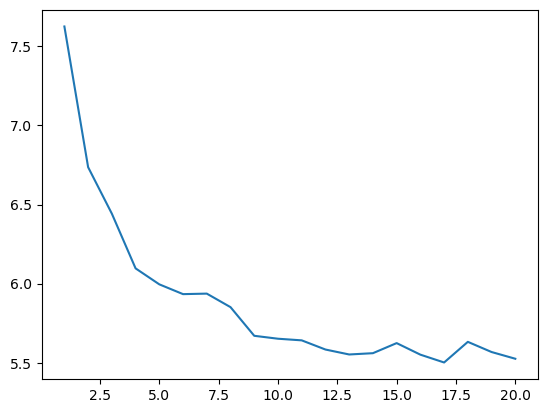

In [38]:
#-----------------
# Lista para almacenar los valores de perplejidad calculados al final de cada época
#-----------------
history_ppl = []

#-----------------
# Ajuste del modelo
#-----------------
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

#-----------------
# Entrenamiento
#-----------------
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

El gráfico anterior de perplejidad en función de las épocas muestra que:
- la perplejidad disminuye a medida que avanza el entrenamiento, lo que indica que el modelo está mejorando en su capacidad para predecir las secuencias de caracteres en el conjunto de validación.
- el aprendizaje es más rápido durante las primeras épocas. Esto es típico en muchos modelos de aprendizaje profundo, donde las mayores ganancias se producen al principio.
- después de la décima época, la perplejidad comienza a estabilizarse con algunas fluctuaciones. Esto podría indicar que el modelo está llegando a un punto de saturación donde las mejoras adicionales son menores. Las fluctuaciones podrían deberse a variaciones naturales en los datos de validación o a pequeños ajustes en los pesos del modelo.
- no hay aumento significativo de la perplejidad en las últimas épocas, lo que sugiere que el modelo no está sobreajustando los datos de entrenamiento. El early stopping no fue necesario en este caso, ya que el modelo continuó mejorando o manteniéndose estable.

Por lo anterior, se deduce que el modelo mejoró constantemente, mostrando un entrenamiento exitoso, lo que sugiere que sea efectivo para la tarea de predicción de secuencias de caracteres.

Así, se carga el mejor modelo que será usado para hacer las inferencias:

In [40]:
#-----------------
# Cargando el mejor modelo
#-----------------
model = keras.models.load_model('my_model.keras')

## **5. Generación de caracteres**

En la siguiente celda se implementa una interfaz interactiva y simple, que permite probar fácilmente cómo el modelo de lenguaje basado en caracteres predice continuaciones de texto. La interfaz es creada con Gradio, una biblioteca que permite crear interfaces web simples para modelos de machine learning.

El usuario ingresa un texto en el cuadro de texto `human_text` y el modelo generará un carácter adicional que es la predicción más probable de cuál sería el siguiente carácter en la secuencia. 

In [53]:
def model_response(human_text):

    #-----------------
    # Codificación del texto
    #-----------------
    encoded = [char2idx[ch] for ch in human_text.lower() ]

    #-----------------
    # Asegurando que la secuencia codificada tenga la longitud el tamaño del contexto
    #-----------------
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    #-----------------
    # Predicción softmax
    #-----------------
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])

    #-----------------
    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    #-----------------
    out_word = ''
    out_word = idx2char[y_hat]

    #-----------------
    # Agrego la palabra a la frase predicha
    #-----------------
    return human_text + out_word


#-----------------
# Interfaz de Gradio
#-----------------
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Keyboard interruption in main thread... closing server.


## **6. Generación de secuencias por Greedy Search**

La metodología Greedy Search (búsqueda codiciosa) es una estrategia simple para crear secuencias en tareas de generación de texto. En esta metodología se selecciona el token (o carácter) que tenga la mayor probabilidad predicha por el modelo en ese momento. Es un enfoque "codicioso" porque siempre elige la opción que parece ser la mejor en el momento, sin considerar las posibles mejores secuencias que podrían surgir al explorar otras opciones con menores probabilidades.

La función `generate_seq` implementa este método tomando un texto inicial y generando una secuencia extendida de texto al predecir un carácter a la vez, utilizando el modelo de caracteres escogido. En cada iteración, codifica el texto actual, predice el siguiente carácter, lo decodifica, y lo agrega al texto. Este proceso se repite hasta que se ha generado el número deseado de caracteres adicionales (`n_words`).

In [43]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text

    #-----------------
	# Generando un numero fijo de palabras
    #-----------------
    for _ in range(n_words):
        #-----------------
		# Codificando el texto
        #-----------------
        encoded = [char2idx[ch] for ch in output_text.lower() ]

        #-----------------
		# Padding de la secuencia
        #-----------------
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		#-----------------
        # Predicción softmax
        #-----------------
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])

        #-----------------
		# Concatenando las predicciones
        #-----------------
        out_word = ''

        out_word = idx2char[y_hat]

        #-----------------
		# Agregando las palabras a la frase predicha
        #-----------------
        output_text += out_word
    return output_text

La función anterior se implementa ahora con un ejemplo de texto con términos financieros:

In [59]:
input_text='the company reported high earnings during the last'

generate_seq(model, input_text, max_length=max_context_size, n_words=50)

'the company reported high earnings during the last year and the bank of the bank of the bank of the '

Cuantas más palabras se agreguen al texto de entrada, mejor es la predicción de las primeras palabras generadas. Sin embargo, al aumentar `n_words` la calidad de la predicción de las últimas palabras generadas disminuye y el texto pierde sentido, al volverse repetitivo como se observa en el caso anterior.

Esto se debe a que los modelos RNN estándar tienen una capacidad limitada para recordar información a lo largo de secuencias largas. En otras palabras, después de un cierto número de caracteres, el modelo puede "olvidar" el contexto original y comenzar a repetir patrones aprendidos.

Además, el modelo ha sido entrenado en un conjunto de datos reducido donde ciertas frases o patrones se repiten con frecuencia. Como consecuencia, el modelo aprende a repetir esas secuencias cuando no está seguro de qué generar a continuación, llevando a predicciones muy determinísticas y repetitivas.

## **7. Generación de secuencias por Beam Search**

Beam Search es una estrategia más avanzada que Greedy Search para la generación de secuencias pues este método explora múltiples caminos simultáneamente para encontrar la secuencia más probable de una manera más global.

Beam Search mantiene un conjunto de los k mejores caminos (secuencias parciales) en cada paso. Este conjunto de caminos se conoce como el "beam" o haz. El parámetro k determina cuántos caminos se exploran en paralelo. Un k mayor significa que más opciones se consideran, lo que generalmente lleva a secuencias de mayor calidad, pero también requiere más memoria y tiempo de cómputo.

En cada paso, el modelo predice las probabilidades para todos los posibles caracteres siguientes. Cada camino en el beam se expande con todos estos posibles caracteres, generando nuevas secuencias. Luego, se seleccionan las k secuencias con mayor probabilidad acumulada (considerando la probabilidad total de cada secuencia hasta el momento) para continuar con el siguiente paso. Las secuencias menos probables se podan o eliminan.

In [69]:
#-----------------
# funcionalidades para hacer encoding y decoding
#-----------------
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq if ch != 0])

#-----------------
# función que selecciona candidatos para el beam search
#-----------------
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):
  #-----------------
  # colectando todas las probabilidades para la siguiente búsqueda
  #-----------------
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)
  
  #-----------------
  # criterio de selección
  #-----------------
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  #-----------------
  # traducir a índices de token en el vocabulario
  #-----------------
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  #-----------------
  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  #-----------------
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


#-----------------
# Implementando beam search
#-----------------
def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    #-----------------
    # codificando el texto
    #-----------------
    encoded = encode(input)

    #-----------------
    # Primera prediccion
    #-----------------
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    #-----------------
    # obteniendo tamaño del vocabulario
    #-----------------
    vocab_size = y_hat.shape[0]

    #-----------------
    # Inicializando la historia
    #-----------------
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    #-----------------
    # seleccionando los num_beams candidatos
    #-----------------
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    #-----------------
    # Ciclo de busqueda del beam
    #-----------------
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        #-----------------
        # actualizando la secuencia de tokens
        #-----------------
        input_update = np.array([hist[i+1:]]).copy()

        #-----------------
        # predicción
        #-----------------
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

### **7.1 Predicción con Beam Search determinístico**

En el siguiente ejemplo se usa el texto introducido anteriormente para el caso de Greedy Search, pero esta vez se genera una secuencia de caracteres con un Beam Search determinístico:

In [74]:
#-----------------
# predicción con beam search
#-----------------
salidas = beam_search(model,num_beams=10,num_words=50,input=input_text)

#-----------------
# Mostrando las salidas
#-----------------
for i, encoded_seq in enumerate(salidas):
    decoded_text = decode(encoded_seq)
    print(f"Texto decodificado {i+1}:\n{decoded_text}\n")

Texto decodificado 1:
the company reported high earnings during the last year. The company's financial company's financial

Texto decodificado 2:
the company reported high earnings during the last year. The company's first quarter. The company's 

Texto decodificado 3:
the company reported high earnings during the last year. The company's financial reporting by  March

Texto decodificado 4:
the company reported high earnings during the last year. The company's financial reporting by  Monda

Texto decodificado 5:
the company reported high earnings during the last year. The company's first quarter. The company, w

Texto decodificado 6:
the company reported high earnings during the last year. The company's first quarter. The company wi

Texto decodificado 7:
the company reported high earnings during the last year. The company's first quarter. The company sa

Texto decodificado 8:
the company reported high earnings during the last year. The company's first quarter. The company co

Texto de

En este caso, la selección es completamente determinista y no depende de la temperatura. Por lo tanto, siempre se seleccionan las secuencias con las mayores probabilidades calculadas, lo que resulta en las mismas salidas cada vez que se ejecuta el método.

### **7.2 Predicción con Beam Search estocástico**

El modo estocástico de Beam Search introduce aleatoriedad en el proceso de selección de secuencias, permitiendo que se exploren diferentes rutas de generación de texto en lugar de siempre seleccionar las opciones más probables de manera determinista. Esto puede llevar a secuencias más variadas y menos predecibles.

Aquí, la temperatura afecta la aleatoriedad de la selección, y por lo tanto, el resultado puede variar en cada ejecución, incluso si la entrada es la misma.

Por ejemplo, si la temperatura es 1, entonces la distribución de probabilidades no será afectada y el softmax aplicado será estándar:

In [81]:
#-----------------
# predicción con beam search
#-----------------
salidas = beam_search(model,num_beams=10,num_words=50,input=input_text,temp=1,mode='sto')

#-----------------
# Mostrando las salidas
#-----------------
for i, encoded_seq in enumerate(salidas):
    decoded_text = decode(encoded_seq)
    print(f"Texto decodificado {i+1}:\n{decoded_text}\n")

Texto decodificado 1:
the company reported high earnings during the last year. The company said in the company will percen

Texto decodificado 2:
the company reported high earnings during the last year. The company said in the company will of the

Texto decodificado 3:
the company reported high earnings during the last year. The company said in the company will of the

Texto decodificado 4:
the company reported high earnings during the last year. The company said in the company will of the

Texto decodificado 5:
the company reported high earnings during the last year. The company said in the company will percen

Texto decodificado 6:
the company reported high earnings during the last year. The company said in the company will percen

Texto decodificado 7:
the company reported high earnings during the last year. The company said in the company will of the

Texto decodificado 8:
the company reported high earnings during the last year. The company said in the company will of the

Texto de

Si la temperatura es menor que 1, la distribución es más aguda, lo que refuerza las diferencias en las probabilidades. Las opciones más probables se vuelven aún más probables, y las opciones menos probables tienen menos chance de ser seleccionadas:

In [80]:
#-----------------
# predicción con beam search
#-----------------
salidas = beam_search(model,num_beams=10,num_words=50,input=input_text,temp=0.1,mode='sto')

#-----------------
# Mostrando las salidas
#-----------------
for i, encoded_seq in enumerate(salidas):
    decoded_text = decode(encoded_seq)
    print(f"Texto decodificado {i+1}:\n{decoded_text}\n")

Texto decodificado 1:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 2:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 3:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 4:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 5:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 6:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 7:
the company reported high earnings during the last year and the bank of the company said the company

Texto decodificado 8:
the company reported high earnings during the last year and the bank of the company said the company

Texto de

Si la temperatura es mayor que 1, las probabilidades se distribuyen más uniformemente. Esto significa que incluso las opciones con probabilidades más bajas tienen una mayor posibilidad de ser seleccionadas, aumentando el riesgo de pérdida de contexto y sentido:

In [83]:
#-----------------
# predicción con beam search
#-----------------
salidas = beam_search(model,num_beams=10,num_words=50,input=input_text,temp=3,mode='sto')

#-----------------
# Mostrando las salidas
#-----------------
for i, encoded_seq in enumerate(salidas):
    decoded_text = decode(encoded_seq)
    print(f"Texto decodificado {i+1}:\n{decoded_text}\n")

Texto decodificado 1:
the company reported high earnings during the last matter with Tosa, ained with To a remponition, mp

Texto decodificado 2:
the company reported high earnings during the last matter with Tosa, ained with To a remponitial wit

Texto decodificado 3:
the company reported high earnings during the last matter with Tosa, ained with To a remponition,  q

Texto decodificado 4:
the company reported high earnings during the last matter with Tosa, ained with To a remponition, tr

Texto decodificado 5:
the company reported high earnings during the last matter with Tosa, ained with To a remponitial wil

Texto decodificado 6:
the company reported high earnings during the last matter with Tosa, ained with To a remponition,  s

Texto decodificado 7:
the company reported high earnings during the last matter with Tosa, ained with To a remponitial wiv

Texto decodificado 8:
the company reported high earnings during the last matter with Tosa, ained with To a remponition, th

Texto de